# O3 Air Pollution Predictive Modelling.

Imports

In [109]:
#data frame
import pandas as pd
import numpy as np

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# machine laerning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_val_predict

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer


from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn import preprocessing
from scipy.stats import pearsonr, spearmanr


## Time series analysis

Reading in data

In [2]:
# Loading the dataset
df = pd.read_csv('India_complete_day.csv', low_memory=False)

# Parse datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract useful time features
#df['hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['dayofweek'] = df['datetime'].dt.dayofweek
df['year'] = df['datetime'].dt.year
# convert StationId to integer labels
df['stationid_int'], uniques = pd.factorize(df['StationId'])


# Displaying the first few rows of the dataframe
print(df.head())

    datetime StationId                     StationName       City  \
0 2017-11-24     AP001  Secretariat, Amaravati - APPCB  Amaravati   
1 2017-11-25     AP001  Secretariat, Amaravati - APPCB  Amaravati   
2 2017-11-26     AP001  Secretariat, Amaravati - APPCB  Amaravati   
3 2017-11-27     AP001  Secretariat, Amaravati - APPCB  Amaravati   
4 2017-11-28     AP001  Secretariat, Amaravati - APPCB  Amaravati   

            State        lat        lon  Status  PM2.5    PM10  ...    CO  \
0  Andhra Pradesh  16.494222  80.510586  Active  71.36  115.75  ...  0.10   
1  Andhra Pradesh  16.494222  80.510586  Active  81.40  124.50  ...  0.12   
2  Andhra Pradesh  16.494222  80.510586  Active  78.32  129.06  ...  0.14   
3  Andhra Pradesh  16.494222  80.510586  Active  88.76  135.32  ...  0.11   
4  Andhra Pradesh  16.494222  80.510586  Active  64.18  104.09  ...  0.09   

     SO2      O3    AQI  AQI_Bucket  month  day  dayofweek  year  \
0  10.76  109.26    NaN         NaN     11   24       

Descriptive Stats

In [93]:
# Summary statistics for numeric variables
def summary_stats(df):

    # print nimber of stations
    print(f"Number of unique stations: {df['StationId'].nunique()}")
    
    print("Descriptive Statistics:")
    # for hour
    #df_desc = df.drop(['hour', 'month', 'dayofweek', 'datetime', 'lat', 'lon', 'day'], axis=1)

    df_desc = df.drop(['month', 'dayofweek', 'datetime', 'lat', 'lon', 'day'], axis=1)
    print(df_desc.describe())

    print("Missing Values:")
    print(df.isnull().sum())

#summary_stats(df)

In [4]:
def o3_stats(df):
    # Print O3 statistics
    print(f"\nO3 Statistics:")
    print(f"Mean O3: {df['O3'].mean():.2f}")
    print(f"Median O3: {df['O3'].median():.2f}")
    print(f"Min O3: {df['O3'].min():.2f}")
    print(f"Max O3: {df['O3'].max():.2f}")

#o3_stats(df)

Map visualsation

In [5]:
def map_vis(df):

    # Load Natural Earth countries (1:110m resolution)
    url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
    world = gpd.read_file(url)

    # Filter for India
    india = world[world["ADMIN"] == "India"]


    # grouping by city as hard to see individual points otherwise

    # groups by city and takes mean of O3 values
    df_mean = df.groupby(['City']).mean('O3').reset_index()
    # Remove rows with NaN values in or 'O3' columns
    df_clean = df_mean.dropna(subset=["O3"])

    gdf = gpd.GeoDataFrame(
        df_clean,  # remove NaNs
        geometry=gpd.points_from_xy(df_clean["lon"], df_clean["lat"]),
        crs="EPSG:4326"
    )

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(8, 10))
    india.plot(ax=ax, color="white", edgecolor="black")  # India boundary

    # Scatter plot of O3 levels
    gdf.plot(
        ax=ax,
        column="O3",        # pollutant column
        cmap="coolwarm",        # color scheme
        markersize=80,      # adjust dot size
        alpha=0.8,
        legend=True,
        legend_kwds={
        "label": "O₃ Concentration (µg/m³)",   # ← your legend label
        "shrink": 0.6                         # optional: smaller colorbar
    }
    )

    plt.title("Scatter Map of Ozone (O₃) Levels Across India")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.show()

#map_vis(df)

Visualising time series.

In [6]:
def ozone_time_series(df):
    
    # group by day (drop the time component)
    df_mean = (
        df.groupby(df['datetime'].dt.date)['O3']
        .mean()
        .reset_index()
    )

    # rename for clarity
    df_mean.columns = ['date', 'O3']

    # plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_mean, x='date', y='O3')
    plt.title('Daily Mean Ozone (O₃) Levels Across India')
    plt.xlabel('Date')
    plt.ylabel('O₃ Concentration (µg/m³)')
    plt.tight_layout()
    plt.show()


def all_pollutatants_time_series(df):

    pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

    monthly_mean = (
    df.groupby(pd.Grouper(key='datetime', freq='D'))[pollutants]
      .mean()
      .reset_index()
    )

    # plot on different graphs for clarity

    plt.figure(figsize=(14, 8))
    for i, pollutant in enumerate(pollutants, 1):
        plt.subplot(3, 3, i)
        sns.lineplot(data=monthly_mean, x='datetime', y=pollutant)
        plt.title(f'Daily Mean {pollutant} Levels Across India')
        plt.xlabel('Date')
        plt.ylabel('Concentration (µg/m³)')
        plt.tight_layout()
    plt.show()
    

#ozone_time_series(df)
#all_pollutatants_time_series(df)

Random station ozone time series

In [7]:

def random_station_ozone_time_series(df):

    # select a random city
    random_station = df['StationId'].sample(n=1).values[0]

    df_station = df[df['StationId'] == random_station]

    # group by day (drop the time component)
    df_mean = (
        df_station.groupby(df_station['datetime'].dt.date)['O3']
        .mean()
        .reset_index()
    )

    # rename for clarity
    df_mean.columns = ['date', 'O3']

    # plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_mean, x='date', y='O3')
    plt.title(f'Daily Mean Ozone (O₃) Levels in {df_station["City"].values[0]} (Station {random_station}) ')
    plt.xlabel('Date')
    plt.ylabel('O₃ Concentration (µg/m³)')
    plt.tight_layout()
    plt.show()

# can return a city with no ozone data so may need to rerun to find one that does
#random_station_ozone_time_series(df)

Seasonal Trends

In [8]:
def yearly_fig(df):
    # Extract year from datetime
    # copy to not impact original df
    df_copy = df.copy()
    df_copy['Year'] = df_copy['datetime'].dt.year
    # # Year-over-Year O3 Trend
    yearly_O3 = df_copy.groupby('Year')['O3'].mean().reset_index()

    #print("\nYearly O3 Summary:")
    #print(yearly_O3)

    #plt.figure(figsize=(8, 6))
    plt.plot(yearly_O3['Year'], yearly_O3['O3'], marker='o', linewidth=2, 
             markersize=8, color='darkred')
    plt.title('Year-over-Year O3 Trend', fontsize=16, fontweight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Average O3', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(yearly_O3['Year'])
    plt.tight_layout()
    plt.show()

def monthly_fig(df):
    # Month-over-Month O3 Trend
    monthly_O3 = df.groupby('month')['O3'].mean().reset_index()

    #print("\nMonthly O3 Summary:")
    #print(monthly_O3)

    #plt.figure(figsize=(8, 6))
    plt.plot(monthly_O3['month'], monthly_O3['O3'], marker='o', linewidth=2, 
            markersize=8, color='darkred')
    plt.title('Month-over-Month O3 Trend', fontsize=16, fontweight='bold')
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Average O3', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(monthly_O3['month'])
    plt.tight_layout()
    plt.show()

def day_of_week_fig(df):
    # Day of the week O3 Trend
    day_of_week_O3 = df.groupby('dayofweek')['O3'].mean().reset_index()

    #print("\nDaily O3 Summary:")
    #print(day_of_week_O3)

    #plt.figure(figsize=(8, 6))
    plt.plot(day_of_week_O3['dayofweek'], day_of_week_O3['O3'], marker='o', linewidth=2, 
            markersize=8, color='lightgreen')
    plt.title('Day-Of-The-Week O3 Trend', fontsize=16, fontweight='bold')
    plt.xlabel('DayOfWeek', fontsize=12)
    plt.ylabel('Average O3', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(day_of_week_O3['dayofweek'])
    plt.tight_layout()
    plt.show()

def seasonal_trends(df):

    df_copy = df.copy()
    df_copy['weekday_name'] = df_copy['datetime'].dt.day_name()

    # Visualization
    plt.figure(figsize=(6,5))
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Autumn'

    df_copy['season'] = df_copy['month'].apply(get_season)

    seasonal_summary = df_copy.groupby('season')['O3'].mean().reset_index()
    sns.barplot(x='season', y='O3', data=seasonal_summary, order=['Spring', 'Summer', 'Autumn', 'Winter'])
    plt.title('Average Seasonal O₃ Levels')
    plt.show()

#seasonal_trends(df)
#yearly_fig(df)
#monthly_fig(df)
#day_of_week_fig(df)


Histograms

In [9]:
def histograms(df):
    numeric_features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

    # Create subplots for all histograms
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()  # Make indexing easier

    for i, col in enumerate(numeric_features):
        sns.histplot(df[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].axvline(df[col].median(), color='r', linestyle='--', label='Median'),
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].legend()


    plt.tight_layout()
    plt.show()

#histograms(df)

Correlation matrix

In [10]:
def correlation_matrix(df):

    # Correlation matrix for pollutants.
    df_corr = df.drop(['AQI_Bucket', 'City', 'datetime', 'StationId', 'StationName', 'Status', 'State'], axis=1)
    corr_matrix = df_corr.corr()

    # Show strong correlations with 03
    if 'O3' in corr_matrix.columns:
        O3_corr = corr_matrix['O3'].sort_values(ascending=False)
        print("\nCorrelation with O3:")
        print(O3_corr[1:11])

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')

#correlation_matrix(df)

Covariance Matrix

In [11]:
def cov_matrix(df):

    # Correlation matrix for pollutants.
    df_cov = df.drop(['AQI_Bucket', 'City', 'datetime', 'StationId', 'StationName', 'Status', 'State'], axis=1)
    cov_matrix = df_cov.cov()

    plt.figure(figsize=(14, 10))
    sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap='coolwarm')

#cov_matrix(df)

Distribution of AQI

In [12]:
def aqi_plots(df):
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # 03 distribution
    axes[0].hist(df['AQI'].dropna(), bins=50, color='blue', edgecolor='black')
    axes[0].set_title('Distribution of AQI Values', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('AQI', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].axvline(df['AQI'].mean(), color='red', linestyle='--', label=f'Mean: {df["AQI"].mean():.2f}')
    axes[0].legend()

    # # AQI Bucket distribution
    aqi_bucket_counts = df['AQI_Bucket'].value_counts()
    axes[1].bar(aqi_bucket_counts.index, aqi_bucket_counts.values, color='red', edgecolor='black')
    axes[1].set_title('Distribution of AQI Buckets', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('AQI Bucket', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

#aqi_plots(df)

Top 50 Worst days for O3 pollution all in same place.

In [13]:
def top_O3_days(df):

    df_copy = df.copy()
    df_copy['Year'] = df_copy['datetime'].dt.year
    # Get top 50 days with Highest O3
    top_O3_days = df_copy.nlargest(50, 'O3')[['datetime', 'StationName','O3']]

    print("=" * 50)
    print("Top 50 days with Highest O3")
    print("=" * 50)
    print(top_O3_days.to_string(index=False))

#top_O3_days(df)

Average Pollutant per stations.

In [14]:
def avg_pollutant_by_station(df):

    # pollutant list
    pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

    stations_mean = (
        df.groupby('StationId')[pollutants]
          .mean()
          .reset_index()
    )

    # Stations by average pollutant levels

    # Create subplots: 3 rows × 3 columns
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    axes = axes.flatten()  # make axes 1D for easy looping

    # Plot each pollutant
    for i, pollutant in enumerate(pollutants):
        # Sort stations for that pollutant
        sorted_data = stations_mean[pollutant].sort_values(ascending=False)

        sorted_data.plot(
            kind='barh',
            ax=axes[i],
            color='orange',
            edgecolor='black'
        )
        axes[i].set_title(f'Stations by Average {pollutant}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(f'Average {pollutant} (µg/m³)', fontsize=10)
        axes[i].set_ylabel('Station', fontsize=10)
        axes[i].tick_params(axis='y', labelsize=5)


    plt.tight_layout()
    plt.show()

#avg_pollutant_by_station(df)

Removing outlier station in O3

Nan value analysis.

In [15]:
def nan_by_pollutant(df):

    India = df.copy()

    # Keep only pollutant-related columns
    polls = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','AQI']


    miss_pct = {}
    for c in polls:
        total_valid = India[c].notna().sum() + India[c].isna().sum()  
        miss_pct[c] = (India[c].isna().sum() / total_valid) * 100

    miss_pct = pd.Series(miss_pct).sort_values(ascending=False)
    print("Missing Percentage by Pollutant (%):", miss_pct)

    plt.figure(figsize=(10,5))
    sns.barplot(x=miss_pct.index, y=miss_pct.values, color='seagreen')
    plt.title("Missing Percentage by Pollutant (%)", fontsize=14, fontweight='bold')
    plt.ylabel("Missing Percentage (%)")
    plt.xlabel("Pollutant")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def nan_by_city(df):

    India = df.copy()
    #--------------------------------------------------------------------------------------------------------------------------------
    # Calculate missing rate by city
    # Keep only pollutant-related columns
    polls = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','AQI']
    
    city_miss = India.groupby('City')[polls].apply(lambda x: x.isnull().mean() * 100)
    city_miss_mean = city_miss.mean(axis=1).sort_values(ascending=False)

    print("Top 10 Cities with Highest Missing Rates (%):")
    print(city_miss_mean.head(10))

    plt.figure(figsize=(12,6))
    city_miss_mean.plot(kind='bar', color='salmon')
    plt.title("Average Missing Rate by City (%)")
    plt.ylabel("Missing Percentage (%)")
    plt.xlabel("City")
    plt.show()

    plt.figure(figsize=(12,8))
    sns.heatmap(
        city_miss,
        cmap='YlGnBu',       
        linewidths=0.3,       
        linecolor='white',
        cbar_kws={'label': 'Missing Rate (%)'},
        annot=True,             
        fmt=".1f",            
        annot_kws={'size':8, 'color':'black'} 
    )

    plt.title("City vs Pollutant Missing Rate Heatmap", fontsize=16, fontweight='bold', pad=12)
    plt.xlabel("Pollutant", fontsize=12)
    plt.ylabel("City", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(fontsize=9)
    plt.tight_layout()
    plt.show()

def nan_by_station(df):

    India = df.copy()
    #  Calculate missing rate by monitoring station

    polls = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','AQI']

    station_miss = India.groupby('StationName')[polls].apply(lambda x: x.isnull().mean() * 100)
    station_miss['Average'] = station_miss.mean(axis=1)
    station_miss = station_miss.sort_values('Average', ascending=False)

    print("Top 10 Monitoring Stations with Highest Missing Rates:")
    print(station_miss.head(10))

def nan_percent_by_station(df):

    # pollutant list
    pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

    # Calculate % of NaN values for each pollutant per station
    stations_nan_pct = (
        df.groupby('StationId')[pollutants]
          .apply(lambda x: x.isna().mean() * 100)
          .reset_index()
    )

    # Create subplots: 3 rows × 3 columns
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    axes = axes.flatten()  # make axes 1D for easy looping

    # Plot each pollutant
    for i, pollutant in enumerate(pollutants):
        # Sort stations by % NaN for that pollutant
        sorted_data = stations_nan_pct.sort_values(by=pollutant, ascending=False)

        axes[i].barh(sorted_data['StationId'], sorted_data[pollutant],
                     color='skyblue', edgecolor='black')

        axes[i].set_title(f'% NaN in {pollutant}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('% Missing Values', fontsize=10)
        axes[i].set_ylabel('Station', fontsize=10)
        axes[i].tick_params(axis='y', labelsize=5)

    plt.tight_layout()
    plt.show()

#nan_by_pollutant(df)
#nan_by_city(df)
#nan_by_station(df)
#nan_percent_by_station(df)

imputing for nan values

In [59]:
def knn_impute_selected_stations(df, threshold=30, n_neighbors=3):
    """
    Perform KNN imputation only for stations with < threshold% missing data.

    Parameters:
        df : pd.DataFrame
            Must contain 'StationName' and pollutant columns.
        threshold : float
            Maximum allowed % of missing values to apply KNN imputation.
        n_neighbors : int
            Number of neighbors for KNN imputer.

    Returns:
        pd.DataFrame : Imputed dataframe.
    """

    pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']
    df = df.copy()

    # Compute % of missing values per station across all pollutants
    missing_pct = (
        df.groupby('StationName')[pollutants]
          .apply(lambda x: x.isna().mean().mean() * 100)
    )

    # Select stations with < threshold % missing
    good_stations = missing_pct[missing_pct < threshold].index
    bad_stations = missing_pct[missing_pct >= threshold].index

    print(f"Stations eligible for KNN imputation (<{threshold}% missing): {len(good_stations)}")
    print(f"Stations excluded: {len(bad_stations)}")

    # Initialize KNN imputer
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Separate data
    df_good = df[df['StationName'].isin(good_stations)].copy()
    df_bad = df[df['StationName'].isin(bad_stations)].copy()

    # Apply KNN imputation to good stations only
    df_good[pollutants] = imputer.fit_transform(df_good[pollutants])

    # Combine back
    df_imputed = pd.concat([df_good, df_bad], ignore_index=True)

    return df_imputed


In [ ]:
def fill_missing_median(df, features):
    df_copy = df.dropna(subset=['O3']).copy()
    imputer = SimpleImputer(strategy='median')
    df_copy[features] = imputer.fit_transform(df_copy[features])
    return df_copy

def fill_missing_knn(df, features, n_neighbors=5):
    df_copy = df.dropna(subset=['O3']).copy()
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_copy[features] = imputer.fit_transform(df_copy[features])
    return df_copy

def fill_missing_moving_average(df, features, window=3):
    df_copy = df.dropna(subset=['O3']).copy()
    for col in features:
        df_copy[col] = df_copy[col].fillna(df_copy[col].rolling(window, min_periods=1).mean())
    return df_copy

def fill_missing_regression(df, features, max_iter=10):
    df_copy = df.dropna(subset=['O3']).copy()
    imputer = IterativeImputer(max_iter=max_iter, random_state=42)
    df_copy[features] = imputer.fit_transform(df_copy[features])
    return df_copy


# ------------------------------------------------------------
# Model Evaluation
# ------------------------------------------------------------
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return r2, rmse


# ------------------------------------------------------------
# Main Comparison Function
# ------------------------------------------------------------
def compare_imputation_methods(df, feature_columns):

    imputation_methods = {
        'No Imputation': lambda x, f: x.dropna(subset=f + ['O3']),
        'Median': fill_missing_median,
        'KNN': fill_missing_knn,
        'Moving Avg': fill_missing_moving_average,
        'Regression (MICE)': fill_missing_regression
    }

    results_r2 = {'Random Forest': {}, 'XGBoost': {}}

    for name, func in imputation_methods.items():

        print(f"=== Testing {name} ===")
        df_filled = func(df, feature_columns)

        X = df_filled[feature_columns]
        y = df_filled['O3']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        rf = RandomForestRegressor(n_estimators=120, random_state=42)
        r2_rf, _ = evaluate_model(rf, X_train_scaled, X_test_scaled, y_train, y_test)
        results_r2['Random Forest'][name] = r2_rf

        xgb = HistGradientBoostingRegressor(max_iter=150, random_state=42)
        r2_xgb, _ = evaluate_model(xgb, X_train, X_test, y_train, y_test)
        results_r2['XGBoost'][name] = r2_xgb

        print(f"Random Forest R² = {r2_rf:.3f} | XGBoost R² = {r2_xgb:.3f}")

    # ============================================================
    # Visualization: Advanced Style
    # ============================================================
    
    # Simple, clean style
    sns.set(style="whitegrid")

    # DataFrame from results
    r2_df = pd.DataFrame(results_r2)

    # Basic bar plot
    ax = r2_df.plot(
        kind='bar',
        figsize=(8, 4),
        color=['#68b684', '#3c78d8'],
        edgecolor='black'
    )

    # Titles and labels
    ax.set_title("R² Comparison — With & Without Imputation", fontsize=13)
    ax.set_ylabel("R² Score")
    ax.set_xlabel("Imputation Method")
    ax.set_ylim(0, 1)

    # Show values on bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", fontsize=9)

    plt.tight_layout()
    plt.show()


    return r2_df

# feature_columns = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','hour','month','dayofweek']
#results = compare_imputation_methods(df, feature_columns, sample_n=1000000)
#print(results)
 

In [ ]:
# ========= Imputation Methods (time-series safe, no row dropping) =========
def fill_missing_median_ts(df, feature):
    """Perform median imputation for a single feature (keeps all timestamps)."""
    out = df.copy()
    out[feature] = _ensure_numeric_series(out[feature], feature)
    imp = SimpleImputer(strategy='median')
    out[feature] = imp.fit_transform(out[[feature]])
    return out

def fill_missing_knn_ts(df, feature, n_neighbors=5):
    """Perform KNN imputation for a single feature (keeps all timestamps)."""
    out = df.copy()
    out[feature] = _ensure_numeric_series(out[feature], feature)
    imp = KNNImputer(n_neighbors=n_neighbors)
    out[feature] = imp.fit_transform(out[[feature]])
    return out

def fill_missing_moving_average_ts(df, feature, window=3):
    """Perform moving average imputation (rolling mean) for a single feature."""
    out = df.copy()
    out[feature] = _ensure_numeric_series(out[feature], feature)
    roll = out[feature].rolling(window=window, min_periods=1).mean()
    out[feature] = out[feature].where(~out[feature].isna(), roll)
    return out

def fill_missing_regression_ts(df, feature, extra_features=None, max_iter=10):
    """
    Perform Multiple Imputation by Chained Equations (MICE).
    Safely imputes only the target feature, without dropping rows.
    Automatically selects numeric columns and skips all-NaN predictors.
    """
    out = df.copy()

    # Columns to protect (not used as predictors)
    protected = {'datetime', 'Date', 'StationId', 'StationName', 'City', 'State', 'Status'}

    # Select numeric predictor columns
    if extra_features is not None:
        num_cols = [c for c in extra_features if c in out.columns]
    else:
        num_cols = [c for c in out.columns
                    if (c not in protected)
                    and np.issubdtype(out[c].dtype, np.number)]

    # Ensure the target column is included
    if feature not in num_cols:
        num_cols.append(feature)

    # Convert to numeric and drop columns that are all NaN
    X = out[num_cols].apply(lambda s: pd.to_numeric(s, errors='coerce'))
    X = X.dropna(axis=1, how='all')

    # If the target column is lost, raise an error
    if feature not in X.columns:
        raise ValueError(f"MICE failed: target column '{feature}' became all NaN.")

    # If too few valid predictors exist, fallback to median imputation
    if X.shape[1] < 2:
        print(f"⚠️ Warning: only '{feature}' has valid numeric data. Falling back to median imputation.")
        imp = SimpleImputer(strategy='median')
        out[feature] = imp.fit_transform(out[[feature]])
        return out

    # Perform MICE imputation
    imp = IterativeImputer(max_iter=max_iter, random_state=42)
    X_filled = imp.fit_transform(X)
    X_filled = pd.DataFrame(X_filled, columns=X.columns, index=X.index)

    # Replace only the target column
    out[feature] = X_filled[feature]
    return out

# ========= Main Plotting Function =========
def plot_imputation_timeseries(df, feature='O3', station_id=None, save_fig=True):
    """
    Visualize and compare different imputation methods for a single monitoring station over time.
    Requirements: df must contain ['StationId', 'datetime', feature].
    """

    # Choose the station (default: station with most missing data)
    if station_id is None:
        try:
            missing_counts = df.groupby('StationId')[feature].apply(
                lambda x: pd.to_numeric(x, errors='coerce').isna().sum()
            )
            station_id = missing_counts.idxmax()
        except Exception:
            station_id = df['StationId'].mode().iloc[0]

    print(f"Plotting imputation comparison for Station {station_id}, Feature {feature}")

    # Filter and sort data
    df_station = df[df['StationId'] == station_id].copy()
    if df_station.empty:
        raise ValueError(f"Station '{station_id}' not found in the data.")
    df_station.sort_values('datetime', inplace=True)

    # Original series (with NaNs kept)
    df_station[feature] = pd.to_numeric(df_station[feature], errors='coerce')
    original = df_station[['datetime', feature]].rename(columns={feature: 'Original'})

    # Apply four imputation methods
    extra_feats = [c for c in df_station.columns
                   if c not in {'datetime', 'Date', 'StationId', 'StationName', 'City', 'State', 'Status'}
                   and c != feature
                   and np.issubdtype(df_station[c].dtype, np.number)]

    df_med = fill_missing_median_ts(df_station, feature)
    df_knn = fill_missing_knn_ts(df_station, feature)
    df_mov = fill_missing_moving_average_ts(df_station, feature)
    df_reg = fill_missing_regression_ts(df_station, feature, extra_features=extra_feats or None)

    # Align all results on the same timeline
    merged = original.copy()
    for name, data in [('Median', df_med), ('KNN', df_knn),
                       ('MovingAvg', df_mov), ('Regression', df_reg)]:
        tmp = data[['datetime', feature]].rename(columns={feature: name})
        merged = pd.merge(merged, tmp, on='datetime', how='left')

    # ===== Visualization =====
    sns.set(style="whitegrid", font="Arial", font_scale=1.2)
    plt.figure(figsize=(14, 6), dpi=300)

    # Gray shaded area: missing regions
    nan_mask = merged['Original'].isna()
    if nan_mask.any():
        ymin = np.nanmin(merged[['Original', 'Median', 'KNN', 'MovingAvg', 'Regression']].values)
        ymax = np.nanmax(merged[['Original', 'Median', 'KNN', 'MovingAvg', 'Regression']].values)
        plt.fill_between(merged['datetime'], ymin, ymax,
                         where=nan_mask, color='gray', alpha=0.15,
                         label='Missing Data Region', zorder=1)

    # Imputed series (overlay)
    plt.plot(merged['datetime'], merged['Median'], '--', color='#2e7d32', linewidth=2,
             label='Median Imputation', zorder=3)
    plt.plot(merged['datetime'], merged['KNN'], '--', color='#1565c0', linewidth=2,
             label='KNN Imputation', zorder=3)
    plt.plot(merged['datetime'], merged['MovingAvg'], '--', color='#f9a825', linewidth=2,
             label='Moving Average', zorder=3)
    plt.plot(merged['datetime'], merged['Regression'], '--', color='#7b1fa2', linewidth=2,
             label='Multiple Regression (MICE)', zorder=3)

    # Original curve (broken at NaNs)
    plt.plot(merged['datetime'], merged['Original'], color='#303030',
             linewidth=2.2, alpha=0.85, label='Original Data (with NaN)', zorder=4)

    plt.title(f"{feature} Imputation Comparison — Station {station_id}",
              fontsize=16, fontweight='bold', pad=10)
    plt.xlabel("Date")
    plt.ylabel(f"{feature} Concentration (µg/m³)")
    plt.xticks(rotation=28)
    plt.legend(loc='upper right', frameon=True)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()

    if save_fig:
        fn = f"imputation_comparison_{station_id}_{feature}.png"
        plt.savefig(fn, dpi=300, bbox_inches='tight')
        print(f"✅ Saved high-resolution figure: {fn}")

    plt.show()
    return merged


# ===================== Example Usage =====================
# Make sure df contains: ['StationId', 'datetime', 'O3'] at minimum
#merged = plot_imputation_timeseries(df, feature='O3', station_id='DL005', save_fig=False)


With Kfold validation.

In [ ]:
def evaluate_model(model, X, y, scaling=True, k=5):
    """
    Evaluate model using k-fold cross-validation (default k=5)
    """
    if scaling:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    else:
        X = np.array(X)

    cv = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    return np.mean(scores), np.std(scores)



# ------------------------------------------------------------
# Main Comparison Function
# ------------------------------------------------------------
def compare_imputation_methods(df, feature_columns, sample_n=30000):
    df = df.sample(n=min(sample_n, len(df)), random_state=42)

    imputation_methods = {
        'No Imputation': lambda x, f: x.dropna(subset=f + ['O3']),
        'Median': fill_missing_median,
        'KNN': fill_missing_knn,
        'Moving Avg': fill_missing_moving_average,
        'Regression (MICE)': fill_missing_regression
    }

    results_r2 = {'Random Forest': {}, 'XGBoost': {}}

    for name, func in imputation_methods.items():
        print(f"\n=== Testing {name} ===")
        
        df_filled = func(df, feature_columns)
        X = df_filled[feature_columns]
        y = df_filled['O3']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        rf = RandomForestRegressor(n_estimators=120, random_state=42)
        r2_rf, std_rf = evaluate_model(rf, X, y, scaling=True, k=5)
        results_r2['Random Forest'][name] = r2_rf
        
        xgb = HistGradientBoostingRegressor(max_iter=150, random_state=42)
        r2_xgb, std_xgb = evaluate_model(xgb, X, y, scaling=False, k=5)
        results_r2['XGBoost'][name] = r2_xgb
        
        print(f"Random Forest R² = {r2_rf:.3f} ± {std_rf:.3f} | XGBoost R² = {r2_xgb:.3f} ± {std_xgb:.3f}")


    # ============================================================
    # Visualization: Advanced Style
    # ============================================================
    sns.set(style="whitegrid", font="Arial", font_scale=1.2)
    plt.rcParams['axes.edgecolor'] = '#333333'
    plt.rcParams['axes.linewidth'] = 1.2

    # --- Plot 1: R² Comparison (All Methods) ---
    r2_df = pd.DataFrame(results_r2)
    fig, ax = plt.subplots(figsize=(9,5))
    bar_colors = ['#999999','#88c999','#66b2ff','#f9cc6c','#d48eff']

    bars = r2_df.plot(kind='bar', ax=ax, color=['#68b684','#3c78d8'], width=0.75, edgecolor='black')
    ax.set_title("R² Comparison — With & Without Imputation", fontsize=14, fontweight='bold')
    ax.set_ylabel("R² Score")
    ax.set_xlabel("Imputation Method")
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    # highlight top performer
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3, fontsize=10)
    plt.legend(title="Model", loc='upper left', frameon=False)
    plt.tight_layout()
    plt.show()


    return r2_df


# ============================================================
# Example Usage
# ============================================================
# df = pd.read_csv("India_complete.csv", low_memory=False) 
# feature_columns = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','hour','month','dayofweek']
#results = compare_imputation_methods(df, feature_columns)
#print(results)

## Modelling

data set prep and splitting for modelling

In [51]:
def norm(df, X_feature_columns, target_pollutant = 'O3'):   
    """
    Function to normalise selected features in the dataframe.
    """
    # only normalise pollutant values
    col_to_norm = ['PM2.5','PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']
    col_to_norm.remove(target_pollutant)

    X = df[X_feature_columns]  # Can contain NaN values
    y = df[[target_pollutant]]  # Should not contain NaN
    # ------------------------------------------------------------------------------------------
    # Normalised dataset 
    X_norm = X.copy()
    # Scale only selected columns
    scaler_X = preprocessing.MinMaxScaler()
    X_norm[col_to_norm] = scaler_X.fit_transform(X[col_to_norm])
    scaler_y = preprocessing.MinMaxScaler()
    y_norm = scaler_y.fit_transform(y)

    y_norm_df = pd.DataFrame(y_norm, columns=[target_pollutant], index=y.index)

    df_norm = pd.concat([X_norm, y_norm_df], axis=1)

    return df_norm, scaler_y

def data_splitting(df, X_feature_columns, target_pollutant = 'O3'):

    df_split = df.copy()
    # get unique station names
    stations = df['stationid_int'].unique()
    # shuffle stations
    np.random.seed(42)  # for reproducibility
    np.random.shuffle(stations)
    # split stations into train and test (80-20)
    split_index = int(0.8 * len(stations))
    train_stations = stations[:split_index]
    test_stations = stations[split_index:]
    # create train and test sets based on stations
    train_set = df_split[df_split['stationid_int'].isin(train_stations)]
    test_set = df_split[df_split['stationid_int'].isin(test_stations)]

    # split into X and y
    X_train, X_test = train_set[X_feature_columns], test_set[X_feature_columns]
    y_train, y_test = train_set[target_pollutant], test_set[target_pollutant]

    return X_train, X_test, y_train, y_test

def preprocess(df, feature_columns, target_pollutant = 'O3', scaler = False):

    X_features = [col for col in feature_columns if col != target_pollutant]
    
    # Remove rows where target variable (O3) is missing
    df_clean = df.dropna(subset=[target_pollutant])

    if target_pollutant == 'O3':
        # Remove Punjabi Bagh station due to extreme outlier O3 data
        df_clean = df_clean[df_clean['StationName'] != 'Punjabi Bagh, Delhi - DPCC']

    if scaler == True:
        # normaise fatures
        df_norm, scaler_y = norm(df_clean, X_features, target_pollutant)
    else:
        df_norm = df_clean
        scaler_y = None

    # split data into train and test sets based on stations
    X_train, X_test, y_train, y_test = data_splitting(df_norm, X_features, target_pollutant)

    return X_train, X_test, y_train, y_test, scaler_y


def preprocess_subset(df, feature_columns, target_pollutant = 'O3', subset_size = 10, scaler = False):

    X_features = [col for col in feature_columns if col != target_pollutant]

    # Remove rows where target variable (O3) is missing
    df_clean = df.dropna(subset=[target_pollutant])

    if target_pollutant == 'O3':
        # Remove Punjabi Bagh station due to extreme outlier O3 data
        df_clean = df_clean[df_clean['StationName'] != 'Punjabi Bagh, Delhi - DPCC']


    if scaler == True:
        # normaise fatures
        df_norm, scaler_y = norm(df_clean, X_features, target_pollutant)

    else:
        df_norm = df_clean
        scaler_y = None

    # Get n random stations
    subset_stations = np.random.choice(df_norm['stationid_int'].unique(), size= subset_size, replace=False)

    # Filter
    subset_df = df_norm[df_norm['stationid_int'].isin(subset_stations)]

    # split data into train and test sets based on stations
    X_train, X_test, y_train, y_test = data_splitting(subset_df, X_features, target_pollutant)

    return X_train, X_test, y_train, y_test, scaler_y

#-----------------------------------------------------------------------------------------------

# Potential feature columns and station id
feature_columns = ['PM2.5','PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'month','day', 'year', 'stationid_int']

# Change target polluatant if wanting to predict for different pollutant.
X_train, X_test, y_train, y_test, scaler_y = preprocess(df, feature_columns, target_pollutant= 'O3', scaler = True)

X_train_sub, X_test_sub, y_train_sub, y_test_sub, scaler_y = preprocess_subset(df, feature_columns, target_pollutant= 'O3')

random forest

In [ ]:
def recursive_feature_elimination_forest(X_train, y_train):

    min_features_to_select = 1  # Minimum number of features to consider
    clf = RandomForestRegressor(
            n_estimators=100,
            n_jobs=-1
    )

    rfecv = RFECV(
        estimator=clf,
        step=1,
        scoring='neg_mean_squared_error',
        min_features_to_select=min_features_to_select,
        cv=KFold(5, shuffle=True, random_state=42),
        n_jobs=-1,
        verbose = 1
    )
    rfecv.fit(X_train, y_train)


    # Extract selected & ranked features
    feature_names = X_train.columns
    selected_features = feature_names[rfecv.support_]
    feature_importances = rfecv.estimator_.feature_importances_
    ranked_features = pd.DataFrame({
        "Feature": feature_names,
        "Importance": feature_importances,
        "Rank": rfecv.ranking_
    }).sort_values("Importance", ascending=False).reset_index(drop=True)


    print("\nSelected Features:")
    print(selected_features.tolist())

    print("\nFeature Ranking:")
    print(ranked_features)


    print(f"Optimal number of features: {rfecv.n_features_}")
    
    data = {
        key: value
        for key, value in rfecv.cv_results_.items()
        if key in ["n_features", "mean_test_score", "std_test_score"]
    }
    cv_results = pd.DataFrame(data)
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean test accuracy")
    plt.errorbar(
        x=cv_results["n_features"],
        y=cv_results["mean_test_score"],
        yerr=cv_results["std_test_score"],
    )
    plt.title("Recursive Feature Elimination \nwith correlated features")
    plt.grid()
    plt.show()

    return selected_features, ranked_features


In [ ]:
#selected, ranked = recursive_feature_elimination_forest(X_train_sub, y_train_sub)

In [160]:
def custom_rfecv_rf(X_train, y_train, protected_features= ['month', 'day', 'year'], step=1, cv=5):

    """
    Custom RFECV that protects some features from elimination
    and stores feature importances at each step.
    
    Parameters:
    -----------
    estimator : sklearn estimator
    X_train : pd.DataFrame
    y_train : pd.Series or array
    protected_features : list of column names to never eliminate
    step : int, number of features to remove per iteration
    cv : int, cross-validation folds

    Returns:
    --------
    optimal_features : list of selected features
    """
    if protected_features is None:
        protected_features = []

    X_work = X_train.drop(columns=['stationid_int']).copy()
    features_remaining = list(X_work.columns)
    results = []
    vali_scores = []
    num_pollutants_list = []

    step_counter = 0

    while len([f for f in features_remaining if f not in protected_features]) >= step:

        num_pollutants_list.append(len([f for f in features_remaining if f not in protected_features]))
        
        print(f'Testing with {len([f for f in features_remaining if f not in protected_features])} pollutants as features')

        estimator = RandomForestRegressor(
            n_estimators=100,
            n_jobs=-1
        )

        # Compute CV score on current feature set
        y_pred = cross_val_predict(estimator, X_work[features_remaining], y_train, cv=cv)
        mse = mean_squared_error(y_train, y_pred)
        vali_scores.append(mse)
        
        # Fit estimator
        estimator.fit(X_work[features_remaining], y_train)

        # get importances
        importances = estimator.feature_importances_

        # Store results
        imp_df = pd.DataFrame({
            'feature': features_remaining,
            'importance': importances,
        }).sort_values('importance', ascending=False)
        
        results.append({
            'remaining_features': features_remaining.copy(),
            'importances': imp_df
        })

        # Identify candidates for elimination
        candidates = [f for f in features_remaining if f not in protected_features]
        n_remove = min(step, len(candidates))
        lowest_features = imp_df[imp_df['feature'].isin(candidates)].tail(n_remove)['feature'].tolist()

        # Remove lowest importance features
        for f in lowest_features:
            features_remaining.remove(f)

        # Optional: stop when number of features = number of protected features
        if len([f for f in features_remaining if f not in protected_features]) <= 0:
            break

    best_performance = min(vali_scores)
    best_idx = vali_scores.index(min(vali_scores))
    best_num_features = num_pollutants_list[best_idx]

    print(f"Optimal number of pollutants as features {best_num_features} with mse: {best_performance}")

    history_df = pd.concat([step['importances'].assign(step=i) for i, step in enumerate(results)], ignore_index=True)

    # Extract features from history_df at the best step
    optimal_step_df = history_df[history_df["step"] == best_idx]
    optimal_features = optimal_step_df["feature"].tolist()

    print(f"Optimal features: {optimal_features}")

    plt.plot(num_pollutants_list, vali_scores, marker='o')
    plt.xlabel("Number of pollutant features")
    plt.ylabel("Validation MSE")
    plt.title("RFECV Elimination Curve (Random Forest)")
    plt.grid(True)
    plt.show()

    return optimal_features


In [163]:
protected = ['month', 'day', 'year']  # features to protect

#optimal_features_rf = custom_rfecv_rf(X_train, y_train, protected_features=protected,step=1,cv=5)


In [167]:
def random_forest_grid_search(X_train, X_test, y_train, y_test):

    param_grid = {
    'n_estimators' : [100, 250, 500], 
    'max_features': [0.8, 1],
    'max_samples': [0.8, 1],
    'max_depth': [20, None],
    'ccp_alpha': [0, 0.01],
    'min_samples_leaf': [1,5]
    }

    grid = HalvingGridSearchCV(
        estimator=RandomForestRegressor(n_estimators=100, random_state=1),
        param_grid=param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        return_train_score=True,
        verbose =1,
        aggressive_elimination = True
    )

    grid.fit(X_train.drop(columns=['stationid_int']), y_train)

    print("Best Parameters:", grid.best_params_)
    print("Best Score:", -grid.best_score_)

    return grid.best_params_, grid.best_estimator_


In [ ]:
#best_params_rf, best_model_rf = random_forest_grid_search(X_train_sub, X_test_sub, y_train_sub, y_test_sub)

In [159]:
def random_forest(X_train, X_test, y_train, y_test, regr= None, feature_columns = None, print_res = True, plot_graphs = True, target_pollutant = 'O3'):


    if feature_columns is not None:
        X_train = X_train[feature_columns]
        X_test = X_test[feature_columns]

    # Then create and fit model ONLY on training data
    if regr == None:

        regr = RandomForestRegressor(
            n_estimators=100,
            random_state= 42,
            n_jobs= -1
        )

        regr.fit(X_train.drop(columns=['stationid_int']), y_train.drop(columns=['stationid_int']))

    # Predictions
    y_train_pred = regr.predict(X_train.drop(columns=['stationid_int']))
    y_test_pred = regr.predict(X_test.drop(columns=['stationid_int']))

    # Evaluation
    def evaluate(y_true, y_pred, print_result, dataset_type="Test"):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        nrmse = rmse / y_true.mean()  
        
        # --- Correlations ---
        pearson_r, _ = pearsonr(y_true, y_pred)
        spearman_r, _ = spearmanr(y_true, y_pred)

        if print_result == True:
            print(f"{dataset_type} MAE: {mae:.2f}")
            print(f"{dataset_type} MSE: {mse:.2f}")
            print(f"{dataset_type} RMSE: {rmse:.2f}")
            print(f"{dataset_type} R²: {r2:.2f}")
            print(f"{dataset_type} NRMSE: {nrmse:.2f}")
            print(f"{dataset_type} Person Corr: {pearson_r:.2f}")
            print(f"{dataset_type} Spearman Corr: {spearman_r:.2f}")
            
        return r2, rmse, nrmse, pearson_r, spearman_r

    r2_train, rmse_train, nrmse_train, pearson_train, spearman_train = evaluate(y_train, y_train_pred, print_res, "Train")
    r2_test, rmse_test, nrmse_test, pearson_test, spearman_test = evaluate(y_test, y_test_pred, print_res, "Test")

    def plotting():

        # Feature Importance
        importances = regr.feature_importances_
        feature_names = X_train.drop(columns=['stationid_int']).columns
        feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
        # plot feature importances
        plt.figure(figsize=(10, 6))
        sns.barplot(x=feature_importances, y=feature_importances.index)
        plt.title('Feature Importances from Random Forest')
        plt.xlabel('Importance Score')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.show()

        X_test_date = X_test.copy()

        X_test_date['datetime'] = pd.to_datetime(
        dict(year=X_test_date['year'], month=X_test_date['month'], day=X_test_date['day']),
        errors='coerce'  # invalid dates will become NaT, avoids ValueError
        )
        
        random_station = np.random.choice(X_test_date['stationid_int'].unique())


        mask = X_test_date['stationid_int'] == random_station
        X_test_station = X_test_date.loc[mask]
        y_test_station = y_test[mask.values]
        y_pred_station = y_test_pred[mask.values]

        plt.figure(figsize=(8, 5))
        plt.plot(X_test_station['datetime'][-100:], y_test_station[-100:], label=f'Station = {random_station} Actual {target_pollutant}',  alpha=0.7)
        plt.plot(X_test_station['datetime'][-100:], y_pred_station[-100:], label=f'Station = {random_station} Predicted {target_pollutant}', alpha=0.7)
        plt.xlabel("Date")
        plt.ylabel(f"{target_pollutant} Levels")
        plt.grid(alpha=0.3)
        plt.legend()
        plt.show()

        # Residual Analysis
        residuals = y_test - y_test_pred
        plt.figure(figsize=(10, 5))
        sns.histplot(residuals, kde=True)
        plt.title('Residual Distribution')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

        # plotting tree
        tree_to_plot = regr.estimators_[0]

        plt.figure(figsize=(20, 10))
        plot_tree(tree_to_plot, max_depth = 3, feature_names=X_train.columns.tolist(), filled=True, rounded=True, fontsize=10)
        plt.title("Decision Tree from Random Forest")
        plt.show()

    if plot_graphs == True:
        plotting()

    return regr, r2_test, rmse_test, nrmse_test, pearson_test, spearman_test

In [80]:
# features not using the station id
features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'month',  'year', 'day', 'stationid_int']
#model = random_forest(X_train_sub, X_test_sub, y_train_sub, y_test_sub, feature_columns=features)

xgboost

custom recursive feature elimination from chat as ist boost regressor not compatible with rfecv

In [81]:
from sklearn.base import BaseEstimator, RegressorMixin, clone


# --- 1️⃣ Custom wrapper around HistGradientBoostingRegressor ---
class PermutationImportanceHGBR(BaseEstimator, RegressorMixin):
    def __init__(self, random_state=42, n_repeats=5):
        self.random_state = random_state
        self.n_repeats = n_repeats
        self.model = HistGradientBoostingRegressor(
            random_state=self.random_state
        )

    def fit(self, X, y):
        self.model.fit(X, y)
        # Compute permutation importance on training data
        result = permutation_importance(
            self.model, X, y,
            n_repeats=self.n_repeats,
            random_state=self.random_state,
            scoring='neg_mean_squared_error'
        )
        # Store feature_importances_ so RFECV can use it
        self.feature_importances_ = np.abs(result.importances_mean)
        return self

    def predict(self, X):
        return self.model.predict(X)


# --- 2️⃣ The RFECV function ---
def recursive_feature_elimination_xg(X_train, y_train):
    """
    Perform Recursive Feature Elimination with Cross-Validation (RFECV)
    using HistGradientBoostingRegressor + permutation-based importances.
    """

    # Use our wrapped model
    clf = PermutationImportanceHGBR(
        random_state=42,
        n_repeats=1
    )

    # RFECV setup
    rfecv = RFECV(
        estimator=clf,
        step=1,
        scoring='neg_mean_squared_error',
        min_features_to_select=1,
        cv=KFold(5, shuffle=True, random_state=42),
        n_jobs=1,
        verbose=1
    )

    # Fit
    rfecv.fit(X_train, y_train)

    # Extract selected & ranked features
    feature_names = X_train.columns
    feature_importances = rfecv.estimator_.feature_importances_
    ranked_features = pd.DataFrame({
        "Feature": feature_names,
        "Importance": feature_importances,
        "Rank": rfecv.ranking_
    }).sort_values("Importance", ascending=False).reset_index(drop=True)

    selected_features = ranked_features.loc[ranked_features["Rank"] == 1, "Feature"]
    
    print("\n✅ Selected Features:")
    print(selected_features.tolist())

    print("\n🏅 Feature Ranking:")
    print(ranked_features)

    print(f"\n⭐ Optimal number of features: {rfecv.n_features_}")

    # --- Plot CV results using modern sklearn ---
    cv_results = pd.DataFrame({
        "n_features": rfecv.cv_results_["n_features"],
        "mean_test_score": rfecv.cv_results_["mean_test_score"],
        "std_test_score": rfecv.cv_results_["std_test_score"]
    })

    plt.figure(figsize=(7, 5))
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean CV Score (neg MSE)")
    plt.errorbar(
        x=cv_results["n_features"],
        y=cv_results["mean_test_score"],
        yerr=cv_results["std_test_score"],
        fmt='-o'
    )
    plt.title("RFECV with Permutation Importances (HistGradientBoosting)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return selected_features, ranked_features


# --- 3️⃣ Example usage ---
#selected, ranked = recursive_feature_elimination_xg(X_train_sub, y_train_sub)


In [152]:
def custom_rfecv_xgb(X_train, y_train, X_features, protected_features= ['month', 'day', 'year'], target_pollutant = 'O3', step=1, cv=5):

    """
    Custom RFECV that protects some features from elimination
    and stores feature importances at each step.
    
    Parameters:
    -----------
    estimator : sklearn estimator
    X_train : pd.DataFrame
    y_train : pd.Series or array
    protected_features : list of column names to never eliminate
    step : int, number of features to remove per iteration
    cv : int, cross-validation folds

    Returns:
    --------
    optimal_features : list of selected features
    """

    # Creating validation set for perutaition importances
    train_df = pd.concat([X_train, y_train], axis=1)

    X_train_split, X_val_split, y_train_split, y_val_split = data_splitting(train_df, X_features, target_pollutant)

    if protected_features is None:
        protected_features = []

    X_work = X_train_split.drop(columns=['stationid_int']).copy()
    X_work_val = X_val_split.drop(columns=['stationid_int']).copy()
    features_remaining = list(X_work.columns)
    results = []
    vali_scores = []
    num_pollutants_list = []

    step_counter = 0

    while len([f for f in features_remaining if f not in protected_features]) >= step:

        num_pollutants_list.append(len([f for f in features_remaining if f not in protected_features]))
        
        print(f'Testing with {len([f for f in features_remaining if f not in protected_features])} pollutants as features')

        estimator = HistGradientBoostingRegressor(
            random_state=42,
            early_stopping = True,
            n_iter_no_change = 10,
            max_iter = 1000)
            
        # Compute CV score on current feature set
        y_pred = cross_val_predict(estimator, X_work[features_remaining], y_train_split, cv=cv)
        mse = mean_squared_error(y_train_split, y_pred)
        vali_scores.append(mse)
        
        # Fit estimator
        estimator.fit(X_work[features_remaining], y_train_split)

        # Calculate permutation importance on test set
        perm_importance = permutation_importance(estimator, X_work_val[features_remaining], y_val_split, random_state=42, n_repeats=5)

        importances = pd.DataFrame({
                'feature': features_remaining,
                'importance': perm_importance.importances_mean
            }).sort_values('importance', ascending=False)


        results.append({
            'remaining_features': features_remaining.copy(),
            'importances': importances
        })

        # Identify candidates for elimination
        candidates = [f for f in features_remaining if f not in protected_features]
        n_remove = min(step, len(candidates))
        lowest_features = importances[importances['feature'].isin(candidates)].tail(n_remove)['feature'].tolist()

        # Remove lowest importance features
        for f in lowest_features:
            features_remaining.remove(f)

        # Optional: stop when number of features = number of protected features
        if len([f for f in features_remaining if f not in protected_features]) <= 0:
            break

    best_performance = min(vali_scores)
    best_idx = vali_scores.index(min(vali_scores))
    best_num_features = num_pollutants_list[best_idx]

    print(f"Optimal number of pollutants as features {best_num_features} with mse: {best_performance}")

    history_df = pd.concat([step['importances'].assign(step=i) for i, step in enumerate(results)], ignore_index=True)

    # Extract features from history_df at the best step
    optimal_step_df = history_df[history_df["step"] == best_idx]
    optimal_features = optimal_step_df["feature"].tolist()

    print(f"Optimal features: {optimal_features}")

    plt.plot(num_pollutants_list, vali_scores, marker='o')
    plt.xlabel("Number of pollutant features")
    plt.ylabel("Validation MSE")
    plt.title("RFECV Elimination Curve (Hist XGBoost)")
    plt.grid(True)
    plt.show()

    return optimal_features

In [162]:
features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'month',  'year', 'day', 'stationid_int']
#optimal_features_xgb = custom_rfecv_xgb( X_train_sub, y_train_sub, features,step=1,cv=5)


In [83]:
#print(selected, ranked)
# top 5 features
#hxb_important = ranked['Feature'].head(9).tolist()
#print(hxb_important)

In [170]:
def xgb_grid_search(X_train, X_test, y_train, y_test):

    param_grid = {
    'max_leaf_nodes' : [31, 100, None], 
    'max_features': [0.8, 1.0],
    'max_depth': [10, None],
    'min_samples_leaf': [5, 25, 100],
    }

    grid = HalvingGridSearchCV(
        estimator= HistGradientBoostingRegressor(max_iter=5000, random_state=42),
        param_grid=param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        return_train_score=True,
        verbose =1,
        aggressive_elimination = True
    )

    grid.fit(X_train.drop(columns=['stationid_int']), y_train)

    print("Best Parameters:", grid.best_params_)
    print("Best Score:", -grid.best_score_)

    return grid.best_params_, grid.best_estimator_


In [156]:
#best_params_xgb, best_model_xgb = xgb_grid_search(X_train_sub, X_test_sub, y_train_sub, y_test_sub)

Plateu of performance after 9 features.

In [158]:
def hxg_boost(X_train, X_test, y_train, y_test, selected_features = None, print_res = True, plot_graphs = True, model = None, target_pollutant = 'O3'):

    if selected_features is not None:
        X_train = X_train[selected_features]
        X_test = X_test[selected_features]

    if model == None:
        # Then create and fit model ONLY on training data
        model = HistGradientBoostingRegressor(
            random_state=42,
            early_stopping = True,
            n_iter_no_change = 100,
            max_iter = 10000
        )

        # Fit directly with NaN values
        model.fit(X_train.drop(columns=['stationid_int']), y_train.drop(columns=['stationid_int']))

    y_pred = model.predict(X_test.drop(columns=['stationid_int']))

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    nrmse = rmse/ y_test.mean()
    # --- Correlations ---
    pearson_r, _ = pearsonr(y_test, y_pred)
    spearman_r, _ = spearmanr(y_test, y_pred)

    if print_res == True:
        print(f'R²: {r2:.3f}')
        print(f'RMSE: {rmse:.3f}')
        print(f'NRMSE: {nrmse:.3f}')
        print(f'MAE: {mae:.3f}')
        print(f'Pearson Corr: {pearson_r:.3f}')
        print(f'Spearman Corr: {spearman_r:.3f}')


    def plotting():

        # --- 4️⃣ Extract training and validation scores ---
        train_scores = -np.array(model.train_score_)  # convert from neg MSE to positive MSE
        val_scores = -np.array(model.validation_score_) if model.validation_score_ is not None else None

        # --- 5️⃣ Plot learning curves ---
        plt.figure(figsize=(8, 5))
        plt.plot(train_scores, label="Training MSE", marker='o', alpha=0.7)
        if val_scores is not None:
            plt.plot(val_scores, label="Validation MSE", marker='s', alpha=0.7)
        plt.xlabel("Boosting Iterations")
        plt.ylabel("Mean Squared Error")
        plt.title("HistGradientBoostingRegressor Learning Curves")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        X_test_date = X_test.copy()

        X_test_date['datetime'] = pd.to_datetime(
        dict(year=X_test_date['year'], month=X_test_date['month'], day=X_test_date['day']),
        errors='coerce'  # invalid dates will become NaT, avoids ValueError
        )
        
        random_station = np.random.choice(X_test_date['stationid_int'].unique())

        mask = X_test_date['stationid_int'] == random_station
        X_test_station = X_test_date.loc[mask]
        y_test_station = y_test[mask.values]
        y_pred_station = y_pred[mask.values]

        plt.figure(figsize=(8, 5))
        plt.plot(X_test_station['datetime'][-100:], y_test_station[-100:], label=f'Station = {random_station} Actual {target_pollutant}',  alpha=0.7)
        plt.plot(X_test_station['datetime'][-100:], y_pred_station[-100:], label=f'Station = {random_station} Predicted {target_pollutant}', alpha=0.7)
        plt.xlabel("Date")
        plt.ylabel(f"{target_pollutant} Levels")
        plt.grid(alpha=0.3)
        plt.legend()
        plt.show()

        # Calculate permutation importance on test set
        perm_importance = permutation_importance(model, X_test.drop(columns=['stationid_int']), y_test, random_state=42, n_repeats=10)
        importances = pd.Series(perm_importance.importances_mean, index=X_train.drop(columns=['stationid_int']).columns).sort_values(ascending=False)

        print("\nPermutation Feature Importances:")
        print(importances)

        plt.figure(figsize=(10,6))
        sns.barplot(x=importances.values, y=importances.index)
        plt.title(f'Permutation Feature Importance for {target_pollutant} Prediction')
        plt.xlabel('Importance Score (Decrease in R² when shuffled)')
        plt.ylabel('Feature')
        plt.show()

        # Residual plot
        residuals = y_test - y_pred
        plt.figure(figsize=(8,6))
        sns.histplot(residuals, kde=True)
        plt.title('Residual Distribution')
        plt.show()

    if plot_graphs == True:
        plotting()

    return model, r2, rmse, nrmse, pearson_r, spearman_r


In [ ]:
# features not using the station id
#features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'month',  'year', 'day', 'stationid_int']
#xgb = hxg_boost(X_train_sub, X_test_sub, y_train_sub, y_test_sub)

Voting Regressor

In [121]:
def voting_reg(X_test_rf, X_test_xgb, y_test, rf_model, xgb_model, print_res = True):

    # Get predictions from both models
    y_pred_rf = rf_model.predict(X_test_rf.drop(columns=['stationid_int']))
    y_pred_xgb = xgb_model.predict(X_test_xgb.drop(columns=['stationid_int']))

    # Simple unweighted average (equal voting)
    y_pred = (y_pred_rf + y_pred_xgb) / 2
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    nrmse = rmse/ y_test.mean()
    # --- Correlations ---
    pearson_r, _ = pearsonr(y_test, y_pred)
    spearman_r, _ = spearmanr(y_test, y_pred)

    if print_res == True:
        print(f'R²: {r2:.3f}')
        print(f'RMSE: {rmse:.3f}')
        print(f'NRMSE: {nrmse:.3f}')
        print(f'MAE: {mae:.3f}')
        print(f'Pearson Corr: {pearson_r:.3f}')
        print(f'Spearman Corr: {spearman_r:.3f}')

    return r2, rmse, nrmse, pearson_r, spearman_r


In [ ]:
def all_pollutant(df, features, subsection = None):

    # list of pollutants
    pollutants = ['PM2.5','PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

    results_df = pd.DataFrame(columns=['Pollutant', 'Model', 'R2', 'RMSE', 'NRMSE', 'Pearson Corr', 'Spearman Corr'])

    for target_pollutant in pollutants:

        print(f'Predicting: {target_pollutant}')

        X_features = [col for col in features if col != target_pollutant]

        if subsection == None:
            # Change target polluatant if wanting to predict for different pollutant.
            X_train, X_test, y_train, y_test, y_scaler = preprocess(df, feature_columns, target_pollutant)

        else:
            X_train, X_test, y_train, y_test, y_scaler = preprocess_subset(df, feature_columns, target_pollutant, subset_size= subsection)

        rf_model, r2_rf, rmse_rf, nrmse_rf, pearson_rf, spearman_rf = random_forest(X_train, X_test, y_train, y_test,
                                               feature_columns= X_features, print_res = False, plot_graphs = False) 

        results_df.loc[len(results_df)] = [target_pollutant, 'RandomForest', r2_rf, rmse_rf, nrmse_rf, pearson_rf, spearman_rf]

        xgb_model, r2_xgb, rmse_xgb, nrmse_xgb, pearson_xgb, spearman_xgb = hxg_boost(X_train,  X_test, y_train, y_test, selected_features= X_features, print_res= False, plot_graphs = False) 

        results_df.loc[len(results_df)] = [target_pollutant, 'HistXGboost', r2_xgb, rmse_xgb, nrmse_xgb, pearson_xgb, spearman_xgb]

        r2_vote, rmse_vote, nrmse_vote, pearson_vote, spearman_vote = voting_reg(X_test, y_test, rf_model, xgb_model, print_res = False)
        
        results_df.loc[len(results_df)] = [target_pollutant, 'Voting Regressor', r2_vote, rmse_vote, nrmse_vote, pearson_vote, spearman_vote]

    print(results_df)

    sns.set_style("whitegrid")

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()  # flatten 2D axes array for easy indexing

    # --- R² Plot ---
    sns.barplot(data=results_df, x='Pollutant', y='R2', hue='Model', ax=axes[0],
                edgecolor='black', linewidth=1.2)
    axes[0].set_title('R² Comparison by Pollutant', fontsize=14)
    axes[0].set_ylabel('R² Score')
    axes[0].set_xlabel('Pollutant')
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].legend(title='Model')

    # --- NRMSE Plot ---
    sns.barplot(data=results_df, x='Pollutant', y='NRMSE', hue='Model', ax=axes[1],
                edgecolor='black', linewidth=1.2)
    axes[1].set_title('NRMSE (mean-normalized) Comparison by Pollutant', fontsize=14)
    axes[1].set_ylabel('NRMSE (mean-normalized)')
    axes[1].set_xlabel('Pollutant')
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].legend(title='Model')

    # --- Pearson r Plot ---
    sns.barplot(data=results_df, x='Pollutant', y='Pearson Corr', hue='Model', ax=axes[2],
                edgecolor='black', linewidth=1.2)
    axes[2].set_title('Pearson Correlation by Pollutant', fontsize=14)
    axes[2].set_ylabel('Pearson r')
    axes[2].set_xlabel('Pollutant')
    axes[2].grid(axis='y', linestyle='--', alpha=0.7)
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].legend(title='Model')

    # --- Spearman r Plot ---
    sns.barplot(data=results_df, x='Pollutant', y='Spearman Corr', hue='Model', ax=axes[3],
                edgecolor='black', linewidth=1.2)
    axes[3].set_title('Spearman Correlation by Pollutant', fontsize=14)
    axes[3].set_ylabel('Spearman r')
    axes[3].set_xlabel('Pollutant')
    axes[3].grid(axis='y', linestyle='--', alpha=0.7)
    axes[3].tick_params(axis='x', rotation=45)
    axes[3].legend(title='Model')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

        

In [ ]:
# All features and stationid
#feature_columns = ['PM2.5','PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'month','day', 'year', 'stationid_int']
#all_pollutant(df, feature_columns)

Full pipeline for a pollutant.

Splitting Dataset
Feature optimisation for Random Forest:
Testing with 8 pollutants as features
Testing with 7 pollutants as features
Testing with 6 pollutants as features
Testing with 5 pollutants as features
Testing with 4 pollutants as features
Testing with 3 pollutants as features
Testing with 2 pollutants as features
Testing with 1 pollutants as features
Optimal number of pollutants as features 8 with mse: 426.4936305433855
Optimal features: ['NO', 'NO2', 'year', 'NH3', 'CO', 'PM10', 'month', 'SO2', 'O3', 'PM2.5', 'day']


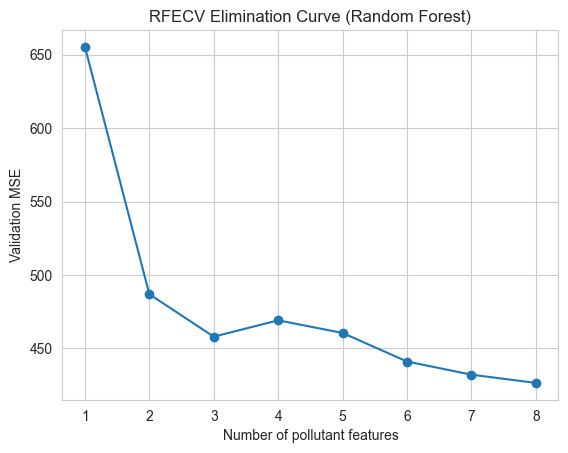

Feature optimisation for HXGB
Testing with 8 pollutants as features
Testing with 7 pollutants as features
Testing with 6 pollutants as features
Testing with 5 pollutants as features
Testing with 4 pollutants as features
Testing with 3 pollutants as features
Testing with 2 pollutants as features
Testing with 1 pollutants as features
Optimal number of pollutants as features 6 with mse: 398.13620692854687
Optimal features: ['NO', 'NO2', 'year', 'month', 'NH3', 'PM10', 'CO', 'PM2.5', 'day']


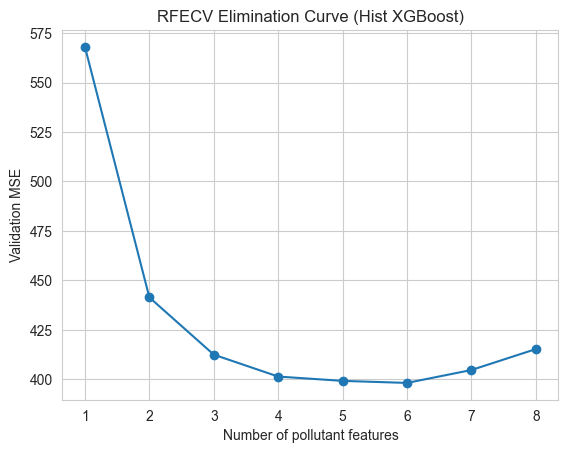

Grid searching best parameters for Random Forest:
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 866
max_resources_: 70146
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 96
n_resources: 866
Fitting 3 folds for each of 96 candidates, totalling 288 fits
----------
iter: 1
n_candidates: 32
n_resources: 2598
Fitting 3 folds for each of 32 candidates, totalling 96 fits
----------
iter: 2
n_candidates: 11
n_resources: 7794
Fitting 3 folds for each of 11 candidates, totalling 33 fits
----------
iter: 3
n_candidates: 4
n_resources: 23382
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 4
n_candidates: 2
n_resources: 70146
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters: {'ccp_alpha': 0, 'max_depth': 20, 'max_features': 0.8, 'max_samples': 0.8, 'min_samples_leaf': 5, 'n_estimators': 500}
Best Score: 447.0044951898081
Grid searching best parameters for HXGB
n_iterations: 4
n_require

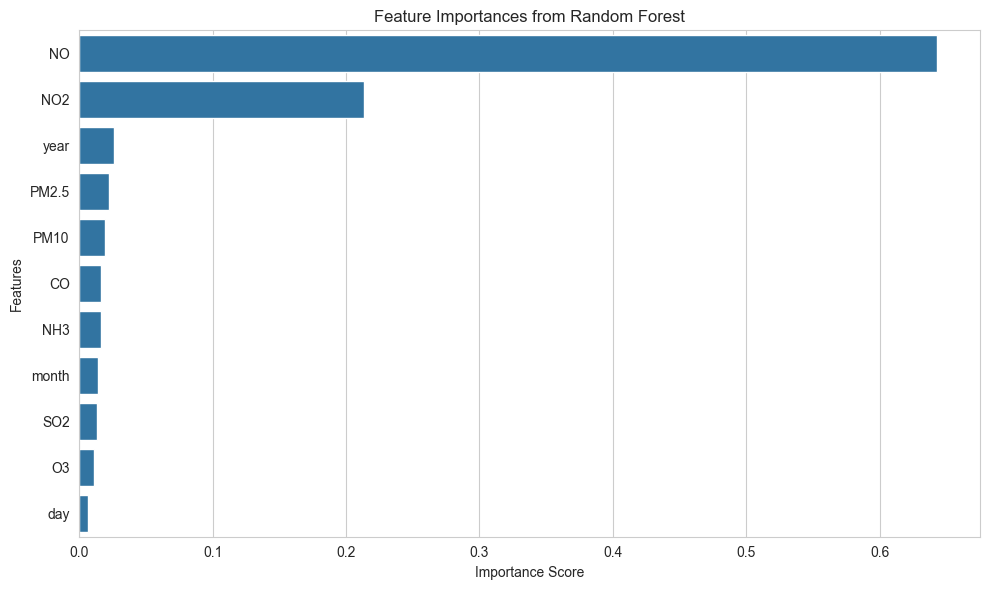

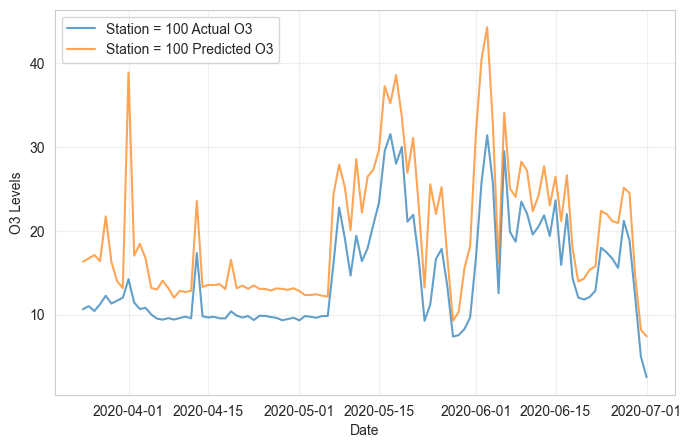

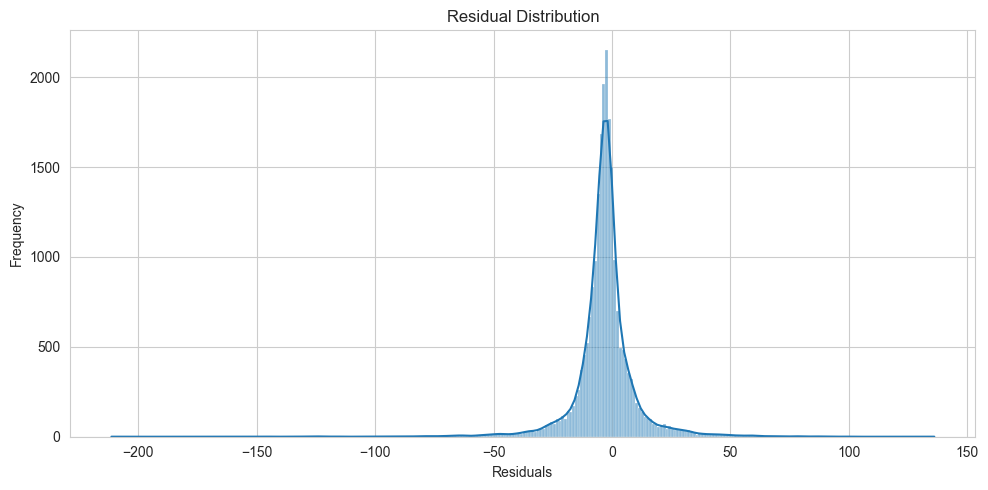

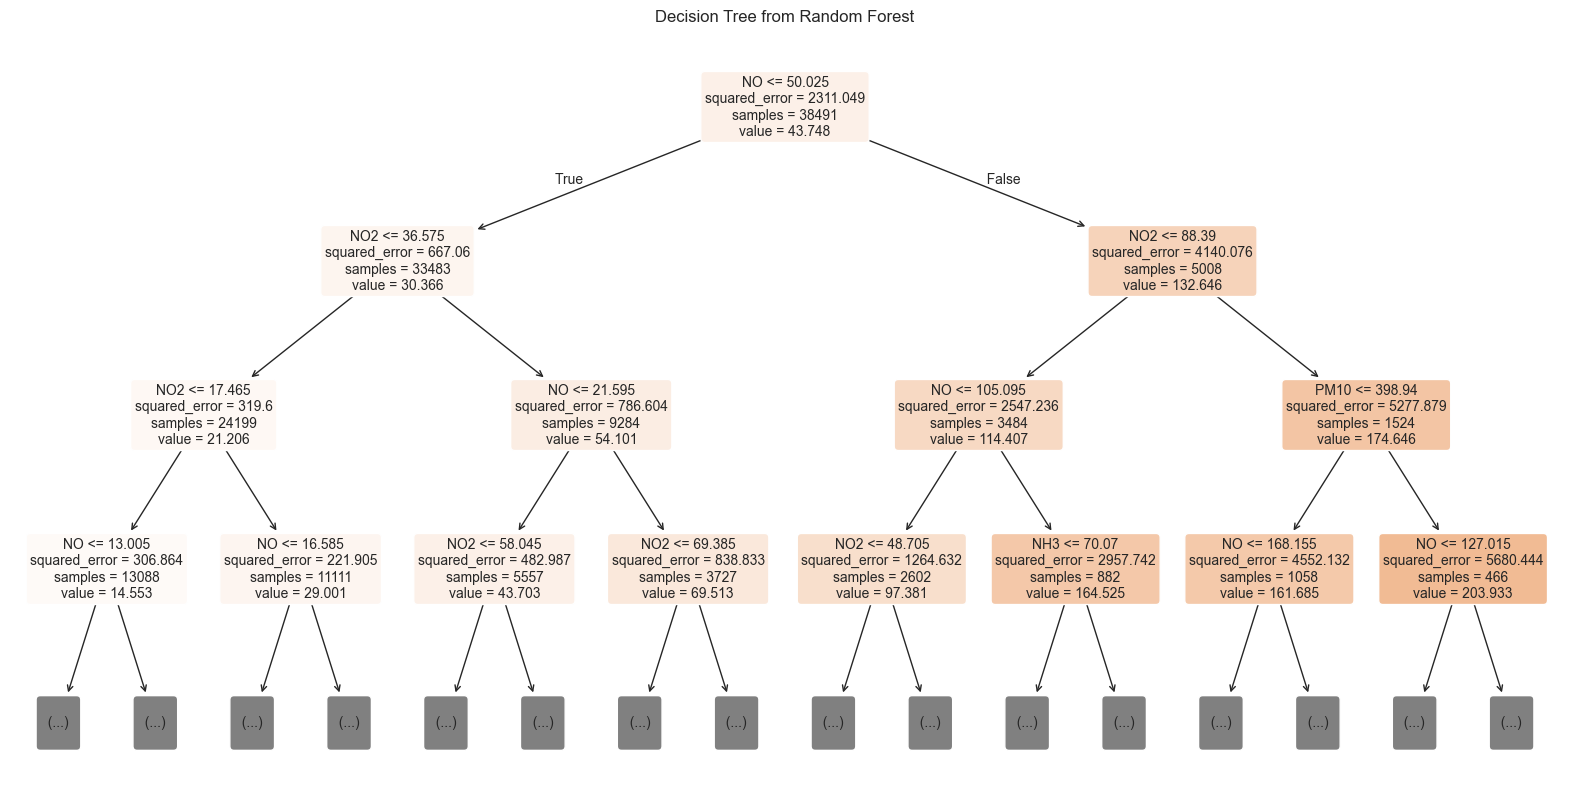

R²: 0.836
RMSE: 13.892
NRMSE: 0.417
MAE: 8.067
Pearson Corr: 0.920
Spearman Corr: 0.847


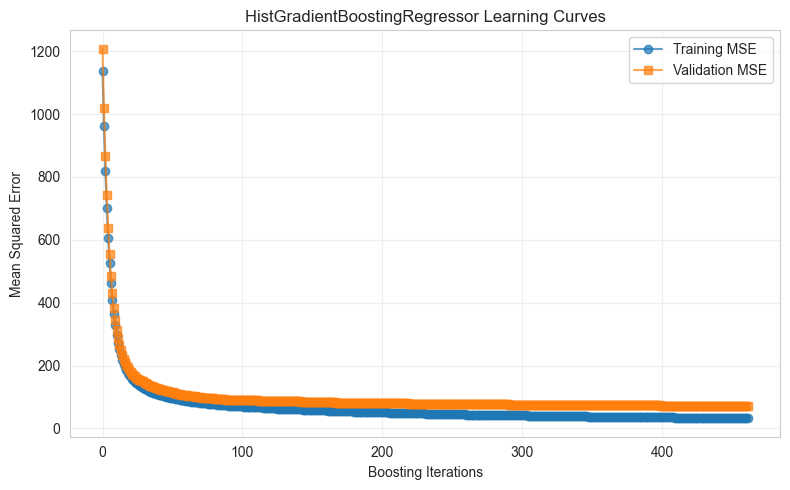

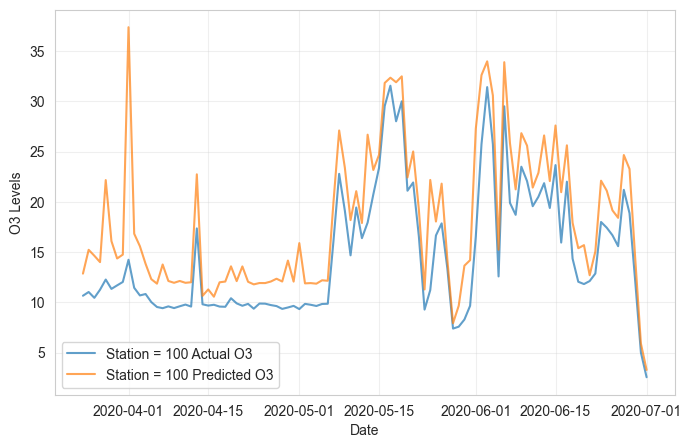


Permutation Feature Importances:
NO       0.886132
NO2      0.278710
year     0.083137
PM10     0.035017
NH3      0.031668
month    0.024172
CO       0.019232
PM2.5    0.006545
day      0.004982
dtype: float64


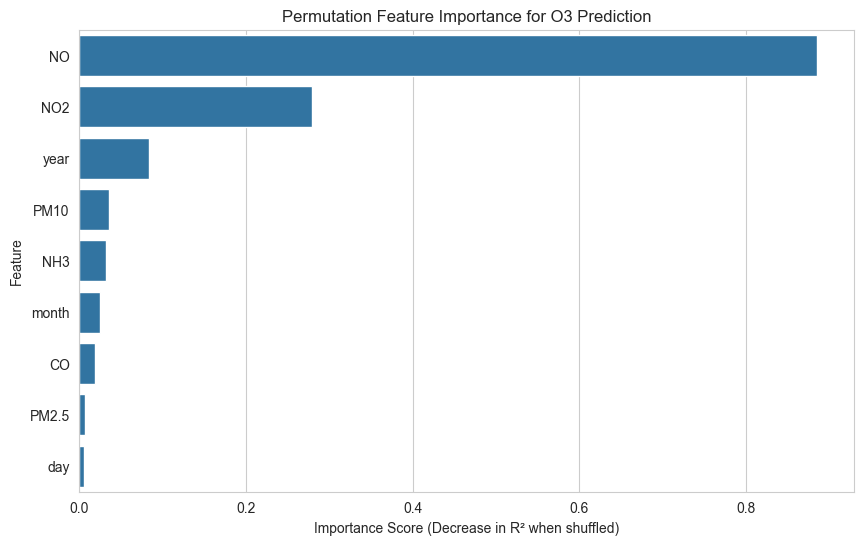

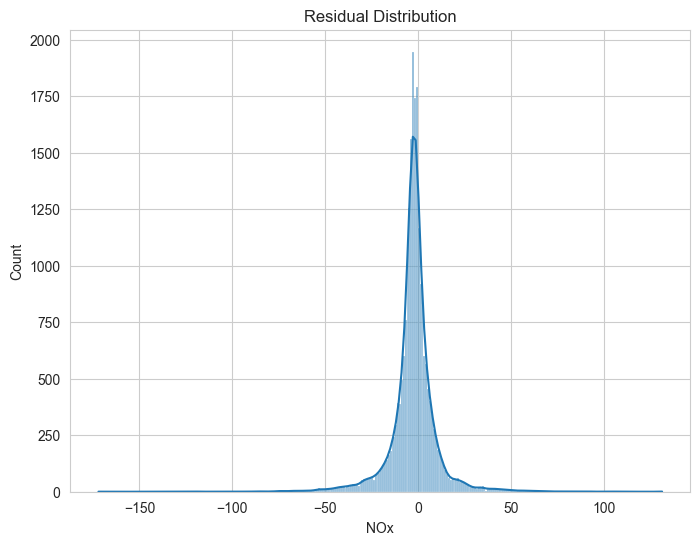

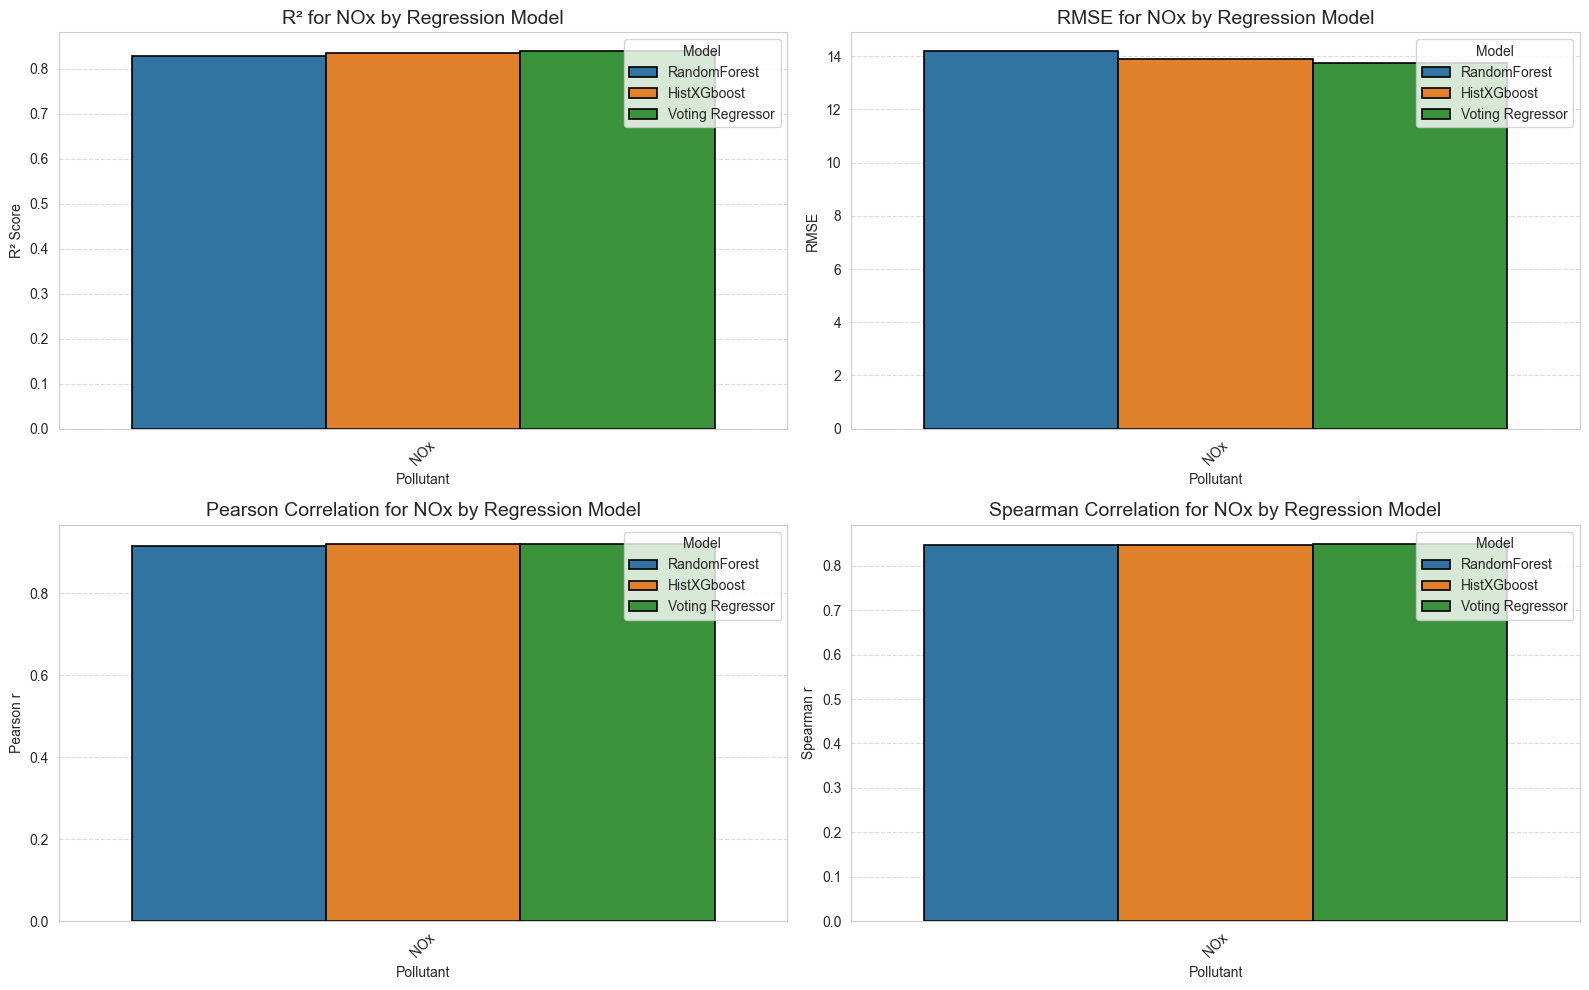

In [171]:
def full_pipeline(df, target_pollutant, feature_columns, subsection = None):

    # -----------------------------------------------------------------------------------------------
    # Split data into train and test
    print('Splitting Dataset')
    # get target feature
    X_features = [col for col in feature_columns if col != target_pollutant]

    if subsection == None:
        # Change target polluatant if wanting to predict for different pollutant.
        X_train, X_test, y_train, y_test, y_scaler = preprocess(df, feature_columns, target_pollutant)

    else:
        X_train, X_test, y_train, y_test, y_scaler = preprocess_subset(df, feature_columns, target_pollutant, subset_size= subsection)

    # ------------------------------------------------------------------------------------------------
    # feature optimisation 

    print('Feature optimisation for Random Forest:')
    optimal_features_rf = custom_rfecv_rf(X_train, y_train, step=1, cv=5)
    print('Feature optimisation for HXGB')
    optimal_features_xgb = custom_rfecv_xgb(X_train, y_train, X_features, step=1, cv=5, target_pollutant= target_pollutant)

    # Need to ensure station is still tracked
    optimal_features_rf.append('stationid_int')
    optimal_features_xgb.append('stationid_int')
    X_train_rf, X_test_rf = X_train[optimal_features_rf], X_test[optimal_features_rf]
    X_train_xgb, X_test_xgb = X_train[optimal_features_xgb],  X_test[optimal_features_xgb]

    # ------------------------------------------------------------------------------------------------
    # Grid search parmeters for selected features to predict with
    print('Grid searching best parameters for Random Forest:')
    best_params_rf, best_model_rf = random_forest_grid_search(X_train_rf, X_test_rf, y_train, y_test)
    print('Grid searching best parameters for HXGB')
    best_params_xgb, best_model_xgb = xgb_grid_search(X_train_xgb, X_test_xgb, y_train, y_test)
    

    #-------------------------------------------------------------------------------------------------
    # predicting with optimised models

    print('Predicting with optimised models:')
    results_df = pd.DataFrame(columns=['Pollutant', 'Model', 'R2', 'RMSE', 'NRMSE', 'Pearson Corr', 'Spearman Corr'])


    rf_model, r2_rf, rmse_rf, nrmse_rf, pearson_rf, spearman_rf = random_forest(X_train_rf, X_test_rf, y_train, y_test,
                                            feature_columns= optimal_features_rf, print_res = True, plot_graphs = True, regr = best_model_rf) 

    results_df.loc[len(results_df)] = [target_pollutant, 'RandomForest', r2_rf, rmse_rf, nrmse_rf, pearson_rf, spearman_rf]

    xgb_model, r2_xgb, rmse_xgb, nrmse_xgb, pearson_xgb, spearman_xgb = hxg_boost(X_train_xgb,  X_test_xgb, y_train, y_test, selected_features= optimal_features_xgb,
                                                                                   print_res= True, plot_graphs = True, model = best_model_xgb) 

    results_df.loc[len(results_df)] = [target_pollutant, 'HistXGboost', r2_xgb, rmse_xgb, nrmse_xgb, pearson_xgb, spearman_xgb]

    r2_vote, rmse_vote, nrmse_vote, pearson_vote, spearman_vote = voting_reg(X_test_rf, X_test_xgb, y_test, best_model_rf, best_model_xgb, print_res = False)
    
    results_df.loc[len(results_df)] = [target_pollutant, 'Voting Regressor', r2_vote, rmse_vote, nrmse_vote, pearson_vote, spearman_vote]


    # ------------------------------------------------------------------------------------------------------------------------------
    # plotting results

    sns.set_style("whitegrid")

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()  # flatten 2D axes array for easy indexing

    # --- R² Plot ---
    sns.barplot(data=results_df, x='Pollutant', y='R2', hue='Model', ax=axes[0],
                edgecolor='black', linewidth=1.2)
    axes[0].set_title(f'R² for {target_pollutant} by Regression Model', fontsize=14)
    axes[0].set_ylabel('R² Score')
    axes[0].set_xlabel('Pollutant')
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].legend(title='Model')

    # --- NRMSE Plot ---
    sns.barplot(data=results_df, x='Pollutant', y='RMSE', hue='Model', ax=axes[1],
                edgecolor='black', linewidth=1.2)
    axes[1].set_title(f'RMSE for {target_pollutant} by Regression Model', fontsize=14)
    axes[1].set_ylabel('RMSE')
    axes[1].set_xlabel('Pollutant')
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].legend(title='Model')

    # --- Pearson r Plot ---
    sns.barplot(data=results_df, x='Pollutant', y='Pearson Corr', hue='Model', ax=axes[2],
                edgecolor='black', linewidth=1.2)
    axes[2].set_title(f'Pearson Correlation for {target_pollutant} by Regression Model', fontsize=14)
    axes[2].set_ylabel('Pearson r')
    axes[2].set_xlabel('Pollutant')
    axes[2].grid(axis='y', linestyle='--', alpha=0.7)
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].legend(title='Model')

    # --- Spearman r Plot ---
    sns.barplot(data=results_df, x='Pollutant', y='Spearman Corr', hue='Model', ax=axes[3],
                edgecolor='black', linewidth=1.2)
    axes[3].set_title(f'Spearman Correlation for {target_pollutant} by Regression Model', fontsize=14)
    axes[3].set_ylabel('Spearman r')
    axes[3].set_xlabel('Pollutant')
    axes[3].grid(axis='y', linestyle='--', alpha=0.7)
    axes[3].tick_params(axis='x', rotation=45)
    axes[3].legend(title='Model')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

    return best_model_rf, best_model_xgb, results_df
    

# All features and stationid
feature_columns = ['PM2.5','PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'month','day', 'year', 'stationid_int']
optimal_rf_model, optimal_xgb_model, optimisation_results_df = full_pipeline(df, 'NOx', feature_columns)

optimisation_results_df.to_csv('Results_NOx.csv', index = False)


Linear Regression

In [ ]:
def linear_model(X_train, X_test, y_train, y_test):

    """
    Linear regression model for O3 preditction.
    Needs imputed data which does not have any Nan values.
    """

    # Fitting model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Output model equation
    coef = pd.Series(model.coef_, index=feature_columns)
    intercept = model.intercept_

    print("Linear Regression Model Formula:")
    eq = f"O₃ = {intercept:.3f}"
    for f, c in coef.items():
        sign = '+' if c >= 0 else '-'
        eq += f" {sign} {abs(c):.3f}×{f}"
    print(eq)

    # Prediction
    y_pred = model.predict(X_test)

    # Evaluation
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"\n📈 Model Performance after Median Imputation:")
    print(f"R² = {r2:.3f}")
    print(f"RMSE = {rmse:.3f}")

# Needs imputed data in form of X_train, X_test, y_train, y_test
#linear_r2, linear_rmse = linear_model()

svm

In [ ]:
def svr_grid_search(X_train, X_test, y_train, y_test):
   
    """
    Perform SVR.
    Needs iputed data with Nans removed.
    """

    # 3. Parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 50, 100],
        'gamma': ['scale', 0.1, 0.01, 0.001],
        'epsilon': [0.01, 0.1, 0.2]
    }


    # 4. Grid Search (Successive Halving)
    grid = HalvingGridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid=param_grid,
        scoring='r2',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    # 5. Output results
    print("Best Parameters Found:")  
    print(grid.best_params_)
    print(f"Best Cross-Validation R²: {grid.best_score_:.3f}")

    return grid.best_params_, grid.best_estimator_

# ------------------------------------------------------------
# Function 2: Run Standard SVR Regression Pipeline
# ------------------------------------------------------------
def run_svr_regression(df, feature_columns, model=None):
    """
    Run SVR training + evaluation pipeline.
    If a tuned model is provided (from svr_grid_search), it will be used directly.
    """

    print(f"Using features: {feature_columns}")

    # ------------------------------------------------------------
    # Train or load model
    # ------------------------------------------------------------

    # Need to define svr model 

    if model is None:
        print("Training default SVR model (C=10, gamma='scale', epsilon=0.1)...")
        model = SVR(kernel='rbf', C=10, gamma='scale', epsilon=0.1)
        model.fit(X_train, y_train)
    else:
        print("Using pretrained/best SVR model from grid search...")
        model.fit(X_train, y_train)

    # ------------------------------------------------------------
    # Predict (inverse transform) 
    # Need to get inverse transform if scaling was applied in y
    # ------------------------------------------------------------

    y_pred_scaled = model.predict(X_test)
    # scaler_y needs to be defined when scaled and imported to function
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    # ------------------------------------------------------------
    # 6. Evaluate
    # ------------------------------------------------------------
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"SVR Model Performance: R² = {r2:.3f}, RMSE = {rmse:.3f}")
    
    print("SVR Pipeline Completed: Data Cleaning + Training + Evaluation Done.")

    return model, r2, rmse


# running model need to fix before uncommenting

# best_params, best_model = svr_grid_search_with_data(X_train, y_train)
# model, r2, rmse = run_svr_regression(X_train, X_test, y_train, y_test)



knn

In [ ]:
def knn_grid_search_with_data(X_train, y_train):
  

    # Need to use imputed data

    # Define parameter grid
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'manhattan', 'euclidean']
    }

    # 4. Grid Search (successive halving)
    grid = HalvingGridSearchCV(
        estimator=KNeighborsRegressor(),
        param_grid=param_grid,
        scoring='r2',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    # Output results
    print("Best Parameters Found:")
    print(grid.best_params_)
    print(f"Best Cross-Validation R²: {grid.best_score_:.3f}")

    return grid.best_params_, grid.best_estimator_

def run_knn_regression(X_train, X_test, y_train, y_test):
   
    # Need to use and imputed and potentially scaled data

    # ------------------------------------------------------------
    # 4. Train KNN model
    # ------------------------------------------------------------
    knn_model = KNeighborsRegressor(
        n_neighbors=5,      # Number of neighbors
        weights='distance', # Weighting method
        metric='minkowski'  # Distance metric
    )
    knn_model.fit(X_train, y_train)

    # ------------------------------------------------------------
    # Prediction
    # ------------------------------------------------------------
    y_pred = knn_model.predict(X_test)

    # ------------------------------------------------------------
    # Evaluation
    # ------------------------------------------------------------
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"\nKNN Model Performance: R² = {r2:.3f}, RMSE = {rmse:.3f}")

    return knn_model, r2, rmse

# Usage needs imputed data and potenially scaled data

#best_params, best_model = knn_grid_search_with_data(X_train, y_train)
#model, r2, rmse = run_knn_regression(X_train, X_test, y_train, y_test)



Neural Net/ lstm 

### comparing results

bar graph of accuracies for with and without imputation of Nan values